# RAG Evaluation


Install packages


In [1]:
!uv pip install -q \
    pandas==2.3.2 \
    pandas-stubs==2.3.2.250827 \
    numpy==2.3.2 \
    matplotlib==3.10.6 \
    seaborn==0.13.2 \
    requests==2.32.5 \
    python-dotenv==1.2.1 \
    tqdm==4.67.1 \
    litellm==1.78.5 \
    elasticsearch==8.19.3 \
    sentence-transformers==5.2.2

Import packages


In [ ]:
import hashlib
import json
import random
import time
import uuid
from collections import defaultdict
from pathlib import Path
from typing import Any, Dict, List, Optional

import litellm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from dotenv import load_dotenv
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

sns.set_style("darkgrid")
sns.set_theme(style="darkgrid")

load_dotenv()

True

## Ground Truth Dataset


Download documents


In [ ]:
docs_url = "https://github.com/alexeygrigorev/llm-rag-workshop/raw/main/notebooks/documents.json"
docs_response = requests.get(docs_url)
documents_raw = docs_response.json()

documents = []

for course in documents_raw:
    course_name = course["course"]
    for doc in course["documents"]:
        doc["course"] = course_name
        documents.append(doc)

documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp'}

Generate document ids based on it's content


In [ ]:
def generate_document_id(doc):
    combined = f"{doc['course']}-{doc['question']}-{doc['text'][:10]}"
    hash_object = hashlib.md5(combined.encode())
    hash_hex = hash_object.hexdigest()
    document_id = hash_hex[:8]

    return document_id

Apply ids


In [ ]:
for doc in documents:
    doc["id"] = generate_document_id(doc)
documents[3]

{'text': "You don't need it. You're accepted. You can also just start learning and submitting homework without registering. It is not checked against any registered list. Registration is just to gauge interest before the start date.",
 'section': 'General course-related questions',
 'question': 'Course - I have registered for the Data Engineering Bootcamp. When can I expect to receive the confirmation email?',
 'course': 'data-engineering-zoomcamp',
 'id': '0bbf41ec'}

Check for duplicates


In [ ]:
hashes = defaultdict(list)

for doc in documents:
    doc_id = doc["id"]
    hashes[doc_id].append(doc)

len(hashes), len(documents)

(947, 948)

Duplicated ids


In [ ]:
for k, v in hashes.items():
    if len(v) > 1:
        print(k, len(v))

593f7569 2


In [ ]:
hashes["593f7569"]

[{'text': "They both do the same, it's just less typing from the script.\nAsked by Andrew Katoch, Added by Edidiong Esu",
  'section': '6. Decision Trees and Ensemble Learning',
  'question': 'Does it matter if we let the Python file create the server or if we run gunicorn directly?',
  'course': 'machine-learning-zoomcamp',
  'id': '593f7569'},
 {'text': "They both do the same, it's just less typing from the script.",
  'section': '6. Decision Trees and Ensemble Learning',
  'question': 'Does it matter if we let the Python file create the server or if we run gunicorn directly?',
  'course': 'machine-learning-zoomcamp',
  'id': '593f7569'}]

Save documents with ids


In [ ]:
with open("documents-with-ids.json", "wt") as f_out:
    json.dump(documents, f_out, indent=2)

In [10]:
!head documents-with-ids.json

[
  {
    "text": "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  \u201cOffice Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon\u2019t forget to register in DataTalks.Club's Slack and join the channel.",
    "section": "General course-related questions",
    "question": "Course - When will the course start?",
    "course": "data-engineering-zoomcamp",
    "id": "c02e79ef"
  },
  {
    "text": "GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites",


In [ ]:
# !docker exec -it ollama ollama pull qwen3:0.6b

In [ ]:
# !docker exec -it ollama ollama list

Lite llm with open router


In [ ]:
response = litellm.completion(
    model="openrouter/meta-llama/llama-3.3-70b-instruct",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": "Explain transformers llm architecture in one paragraph.",
        },
    ],
    # api_base="http://localhost:11434",
    # api_key="ollama",
    # format="json",
    # custom_llm_provider="ollama",
)

print(response.choices[0].message["content"])

The Transformer LLM (Large Language Model) architecture is a type of neural network designed for natural language processing tasks. It's based on the Transformer model, which relies on self-attention mechanisms to weigh the importance of different input elements relative to each other. The architecture consists of an encoder and a decoder, but for LLMs, the decoder is typically used in a auto-regressive manner, generating text one token at a time. The model is composed of multiple identical layers, each comprising two sub-layers: a self-attention mechanism and a position-wise fully connected feed-forward network. The self-attention mechanism allows the model to attend to different parts of the input sequence simultaneously and weigh their importance, while the feed-forward network transforms the output of the self-attention mechanism. This architecture enables the model to capture complex patterns and relationships in language, making it highly effective for tasks such as language tran

Prompt template


In [ ]:
prompt_template = """
You emulate a student who's taking our course.
Formulate 5 questions this student might ask based on a FAQ record. The record
should contain the answer to the questions, and the questions should be complete and not too short.
If possible, use as fewer words as possible from the record.

The record:

section: {section}
question: {question}
answer: {text}

Provide the output in parsable JSON without using code blocks:

["question1", "question2", ..., "question5"]
""".strip()

In [ ]:
def generate_questions(doc):
    prompt = prompt_template.format(**doc)

    response = litellm.completion(
        model="openrouter/meta-llama/llama-3.3-70b-instruct",
        messages=[
            {"role": "user", "content": prompt},
        ],
        format="json",
        # api_base="http://localhost:11434",
        # api_key="ollama",
        # custom_llm_provider="ollama",
    )

    return response.choices[0].message.content

In [ ]:
OUTPUT_PATH = Path("generated_questions.json")

if OUTPUT_PATH.exists():
    with OUTPUT_PATH.open("r", encoding="utf-8") as f:
        results = json.load(f)
else:
    results = {}

In [ ]:
def save_results(data, path=OUTPUT_PATH):
    tmp_path = path.with_suffix(".tmp")
    with tmp_path.open("w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    tmp_path.replace(path)

In [ ]:
for doc in tqdm(documents):
    doc_id = str(doc["id"])

    if doc_id in results:
        continue

    questions = generate_questions(doc)
    results[doc_id] = questions

    save_results(results)

100%|██████████| 948/948 [00:00<00:00, 716819.94it/s]


In [ ]:
def extract_json(text):
    start_idx = text.find("[") if "[" in text else len(text)

    if start_idx == len(text):
        return None

    for end_idx in range(len(text), start_idx, -1):
        try:
            return json.loads(text[start_idx:end_idx])
        except:
            continue
    return None

In [ ]:
parsed_results = {}

for doc_id, questions in results.items():
    try:
        parsed_results[doc_id] = extract_json(questions)
    except Exception as error:
        print(error)
        print(questions)
        break

In [ ]:
doc_index = {d["id"]: d for d in documents}

In [ ]:
final_results = []

for doc_id, questions in parsed_results.items():
    course = doc_index[doc_id]["course"]
    for q in questions:
        final_results.append((q, course, doc_id))

In [ ]:
df = pd.DataFrame(final_results, columns=["question", "course", "document"])
df.head()

,question,course,document
0,What is the exact date and time when our cours...,data-engineering-zoomcamp,c02e79ef
1,How can I stay updated about the course schedu...,data-engineering-zoomcamp,c02e79ef
2,What are the necessary steps I need to take be...,data-engineering-zoomcamp,c02e79ef
3,Where can I find the course calendar and how d...,data-engineering-zoomcamp,c02e79ef
4,What are the different platforms I need to joi...,data-engineering-zoomcamp,c02e79ef


In [ ]:
df.to_csv("ground-truth-data.csv", index=False)

In [25]:
!head ground-truth-data.csv

question,course,document
What is the exact date and time when our course is scheduled to begin,data-engineering-zoomcamp,c02e79ef
How can I stay updated about the course schedule and important announcements,data-engineering-zoomcamp,c02e79ef
What are the necessary steps I need to take before the course starts,data-engineering-zoomcamp,c02e79ef
Where can I find the course calendar and how do I access it,data-engineering-zoomcamp,c02e79ef
What are the different platforms I need to join to be fully registered for the course,data-engineering-zoomcamp,c02e79ef
What do I need to know before enrolling in this course,data-engineering-zoomcamp,1f6520ca
Are there any specific requirements to join this course,data-engineering-zoomcamp,1f6520ca
Do I need prior experience to take this course,data-engineering-zoomcamp,1f6520ca
What are the necessary skills to succeed in this course,data-engineering-zoomcamp,1f6520ca


## Retrieval evaluation

How to know which parameters in search function are the best?

Metrics:

- Hit Rate (HR) or Recall at K (R@K)
- Mean Reciprocal Rank (MRR)


Run Elasticsearch:

```sh
docker run --rm -it \
  --name elasticsearch \
  -p 9200:9200 \
  -p 9300:9300 \
  -e "discovery.type=single-node" \
  -e "xpack.security.enabled=false" \
  -e "xpack.security.http.ssl.enabled=false" \
  -e "xpack.security.transport.ssl.enabled=false" \
  -e "ES_JAVA_OPTS=-Xms2g -Xmx2g" \
  docker.elastic.co/elasticsearch/elasticsearch:8.5.1
```


Create an Elasticsearch client instance


In [ ]:
es_client = Elasticsearch(
    "http://localhost:9200",
)

Check connection


In [ ]:
es_client.info()

ObjectApiResponse({'name': '3d5017a0e840', 'cluster_name': 'docker-cluster', 'cluster_uuid': '6CzLA5N1SRqwcjHVFmO1-Q', 'version': {'number': '8.5.1', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'c1310c45fc534583afe2c1c03046491efba2bba2', 'build_date': '2022-11-09T21:02:20.169855900Z', 'build_snapshot': False, 'lucene_version': '9.4.1', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

Create an index in Elasticsearch


In [ ]:
index_settings = {
    "settings": {"number_of_shards": 1, "number_of_replicas": 0},
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
        }
    },
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [ ]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

100%|██████████| 948/948 [00:06<00:00, 150.19it/s]


In [ ]:
def elastic_search(query, course):
    search_query = {
        "size": 5,
        "query": {
            "bool": {
                "must": {
                    "multi_match": {
                        "query": query,
                        "fields": ["question^3", "text", "section"],
                        "type": "best_fields",
                    }
                },
                "filter": {"term": {"course": course}},
            }
        },
    }

    response = es_client.search(index=index_name, body=search_query)

    result_docs = []

    for hit in response["hits"]["hits"]:
        result_docs.append(hit["_source"])

    return result_docs

In [ ]:
elastic_search(
    query="I just discovered the course. Can I still join?",
    course="data-engineering-zoomcamp",
)

[{'text': "Yes, even if you don't register, you're still eligible to submit the homeworks.\nBe aware, however, that there will be deadlines for turning in the final projects. So don't leave everything for the last minute.",
  'section': 'General course-related questions',
  'question': 'Course - Can I still join the course after the start date?',
  'course': 'data-engineering-zoomcamp',
  'id': '7842b56a'},
 {'text': 'You can start by installing and setting up all the dependencies and requirements:\nGoogle cloud account\nGoogle Cloud SDK\nPython 3 (installed with Anaconda)\nTerraform\nGit\nLook over the prerequisites and syllabus to see if you are comfortable with these subjects.',
  'section': 'General course-related questions',
  'question': 'Course - What can I do before the course starts?',
  'course': 'data-engineering-zoomcamp',
  'id': '63394d91'},
 {'text': 'Yes, we will keep all the materials after the course finishes, so you can follow the course at your own pace after it fin

In [ ]:
df_ground_truth = pd.read_csv("ground-truth-data.csv")
ground_truth = df_ground_truth.to_dict(orient="records")

In [ ]:
relevance_total = []

for q in tqdm(ground_truth):
    doc_id = q["document"]
    results = elastic_search(query=q["question"], course=q["course"])
    relevance = [d["id"] == doc_id for d in results]
    relevance_total.append(relevance)

100%|██████████| 4735/4735 [00:25<00:00, 188.86it/s]


In [ ]:
relevance_total[:10]

[[False, False, True, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, False, False],
 [False, False, False, True, False],
 [True, False, False, False, False],
 [False, False, False, False, False],
 [True, False, False, False, False],
 [True, False, False, False, False]]

In [ ]:
def hit_rate(relevance_total):
    counter = 0

    for row in relevance_total:
        if True in row:
            counter += 1

    return counter / len(relevance_total)

In [ ]:
hit_rate(relevance_total)

0.707286166842661

In [ ]:
def mrr(relevance_total):
    total_score = 0

    for row in relevance_total:
        for rank in range(len(row)):
            if row[rank] == True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

In [ ]:
mrr(relevance_total)

0.5742133051742337

## RAG Evaluation


In [ ]:
model_name = "multi-qa-MiniLM-L6-cos-v1"
model = SentenceTransformer(model_name)

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 747.28it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/multi-qa-MiniLM-L6-cos-v1
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
es_client = Elasticsearch(
    "http://localhost:9200",
    request_timeout=120,
)

In [ ]:
es_client.info()

ObjectApiResponse({'name': '3d5017a0e840', 'cluster_name': 'docker-cluster', 'cluster_uuid': '6CzLA5N1SRqwcjHVFmO1-Q', 'version': {'number': '8.5.1', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'c1310c45fc534583afe2c1c03046491efba2bba2', 'build_date': '2022-11-09T21:02:20.169855900Z', 'build_snapshot': False, 'lucene_version': '9.4.1', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [ ]:
index_settings = {
    "settings": {"number_of_shards": 1, "number_of_replicas": 0},
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine",
            },
        }
    },
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(
    index=index_name, body=index_settings, wait_for_active_shards=1
)
es_client.cluster.health(wait_for_status="yellow", timeout="30s")

ObjectApiResponse({'cluster_name': 'docker-cluster', 'status': 'green', 'timed_out': False, 'number_of_nodes': 1, 'number_of_data_nodes': 1, 'active_primary_shards': 2, 'active_shards': 2, 'relocating_shards': 0, 'initializing_shards': 0, 'unassigned_shards': 0, 'delayed_unassigned_shards': 0, 'number_of_pending_tasks': 0, 'number_of_in_flight_fetch': 0, 'task_max_waiting_in_queue_millis': 0, 'active_shards_percent_as_number': 100.0})

In [ ]:
for doc in tqdm(documents):
    question = doc["question"]
    text = doc["text"]
    doc["question_text_vector"] = model.encode(question + " " + text)

    es_client.index(index=index_name, document=doc, timeout="60s")

100%|██████████| 948/948 [00:39<00:00, 24.09it/s]


In [ ]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {"term": {"course": course}},
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"],
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query,
    )

    result_docs = []

    for hit in es_results["hits"]["hits"]:
        result_docs.append(hit["_source"])

    return result_docs


def question_text_vector_knn(q):
    question = q["question"]
    course = q["course"]

    vector_question = model.encode(question)

    return elastic_search_knn("question_text_vector", vector_question, course)

In [ ]:
question_text_vector_knn(
    dict(
        question="Are sessions recorded if I miss one?",
        course="machine-learning-zoomcamp",
    )
)

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

In [ ]:
def build_prompt(query, search_results):
    prompt_template = """
    You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
    Use only the facts from the CONTEXT when answering the QUESTION

    QUESTION {question}

    CONTEXT:
    {context}
    """.strip()

    context = ""

    for doc in search_results:
        context = (
            context
            + f"section: {doc['question']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
        )

    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [ ]:
def llm(prompt, model="openrouter/meta-llama/llama-3.3-70b-instruct"):
    response = litellm.completion(
        model=model,
        messages=[
            {
                "role": "user",
                "content": prompt,
            },
        ],
    )

    return response.choices[0].message["content"]

In [ ]:
def rag(
    query: Dict[str, str],
    model: Optional[str] = "openrouter/meta-llama/llama-3.3-70b-instruct",
) -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query["question"], search_results)
    answer = llm(prompt, model)

    return answer

In [ ]:
ground_truth[10]

{'question': 'What happens if I miss the course registration deadline, can I still participate?',
 'course': 'data-engineering-zoomcamp',
 'document': '7842b56a'}

In [ ]:
llm_answer = rag(ground_truth[10])
llm_answer

"If you miss the course registration deadline, you can still participate in the course. According to the course policy, registration is just to gauge interest before the start date, and you can start learning and submitting homework without registering. However, be aware that there will be deadlines for turning in the final projects, so it's advised not to leave everything for the last minute."

In [ ]:
original_answer = doc_index["7842b56a"]["text"]
original_answer

"Yes, even if you don't register, you're still eligible to submit the homeworks.\nBe aware, however, that there will be deadlines for turning in the final projects. So don't leave everything for the last minute."

### Cosine Similarity


In [ ]:
llm_answer_vector = model.encode(llm_answer)
original_answer_vector = model.encode(original_answer)

llm_answer_vector.dot(original_answer_vector)

np.float32(0.75114423)

In [ ]:
len(ground_truth)

4735

In [ ]:
OUTPUT_PATH = Path("rag_answers.json")

# if OUTPUT_PATH.exists():
#     with open(OUTPUT_PATH, "r") as f:
#         answers = json.load(f)
#         answers = {int(k): v for k, v in answers.items()}
# else:
#     answers = {}

# for i, rec in tqdm(enumerate(ground_truth)):
#     if i in answers:
#         continue

#     llm_answer = rag(rec)

#     doc_id = rec["document"]
#     original_doc = doc_index[doc_id]

#     answers[i] = {
#         "llm_answer": llm_answer,
#         "original_answer": original_doc["text"],
#         "document": doc_id,
#     }

#     with open(OUTPUT_PATH, "w") as f:
#         json.dump(answers, f, ensure_ascii=False, indent=2)

In [ ]:
with open(OUTPUT_PATH, "r") as f:
    answers = json.load(f)

In [ ]:
ground_truth[1]for

{'question': 'How can I stay updated about the course schedule and important announcements',
 'course': 'data-engineering-zoomcamp',
 'document': 'c02e79ef'}

In [ ]:
answers["1"]

{'llm_answer': "To stay updated about the course schedule and important announcements, you can:\n\n1. Subscribe to the course public Google Calendar (accessible from Desktop only).\n2. Join the course Telegram channel with announcements.\n3. Register in DataTalks.Club's Slack and join the channel.\n4. Check the announcements from @Au-Tomator for any updates or extensions.\n5. Refer to the shared Google spreadsheet (https://docs.google.com/spreadsheets/d/e/2PACX-1vQACMLuutV5rvXg5qICuJGL-yZqIV0FBD84CxPdC5eZHf8TfzB-CJT_3Mo7U7oGVTXmSihPgQxuuoku/pubhtml) for the latest deadlines.",
 'original_answer': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon

In [ ]:
results = [None] * len(answers)

for index, value in answers.items():
    results[int(index)] = value.copy()
    results[int(index)].update(ground_truth[int(index)])

In [ ]:
df = pd.DataFrame(results)
df.head()

,llm_answer,original_answer,document,question,course
0,The exact date and time when our course is sch...,The purpose of this document is to capture fre...,c02e79ef,What is the exact date and time when our cours...,data-engineering-zoomcamp
1,To stay updated about the course schedule and ...,The purpose of this document is to capture fre...,c02e79ef,How can I stay updated about the course schedu...,data-engineering-zoomcamp
2,"Based on the provided context, the necessary s...",The purpose of this document is to capture fre...,c02e79ef,What are the necessary steps I need to take be...,data-engineering-zoomcamp
3,You can find the course calendar by subscribin...,The purpose of this document is to capture fre...,c02e79ef,Where can I find the course calendar and how d...,data-engineering-zoomcamp
4,"To be fully registered for the course, you nee...",The purpose of this document is to capture fre...,c02e79ef,What are the different platforms I need to joi...,data-engineering-zoomcamp


In [ ]:
similarity = []

for result in tqdm(results):
    llm_answer = result["llm_answer"]
    original_answer = result["original_answer"]

    llm_answer_vector = model.encode(llm_answer)
    original_answer_vector = model.encode(original_answer)

    similarity.append(llm_answer_vector.dot(original_answer_vector))

100%|██████████| 874/874 [00:52<00:00, 16.76it/s]


In [ ]:
df["cosine"] = similarity
df.head()

,llm_answer,original_answer,document,question,course,cosine
0,The exact date and time when our course is sch...,The purpose of this document is to capture fre...,c02e79ef,What is the exact date and time when our cours...,data-engineering-zoomcamp,0.699739
1,To stay updated about the course schedule and ...,The purpose of this document is to capture fre...,c02e79ef,How can I stay updated about the course schedu...,data-engineering-zoomcamp,0.763956
2,"Based on the provided context, the necessary s...",The purpose of this document is to capture fre...,c02e79ef,What are the necessary steps I need to take be...,data-engineering-zoomcamp,0.867351
3,You can find the course calendar by subscribin...,The purpose of this document is to capture fre...,c02e79ef,Where can I find the course calendar and how d...,data-engineering-zoomcamp,0.479641
4,"To be fully registered for the course, you nee...",The purpose of this document is to capture fre...,c02e79ef,What are the different platforms I need to joi...,data-engineering-zoomcamp,0.765339


In [ ]:
df.cosine.describe()

count    874.000000
mean       0.678854
std        0.184091
min       -0.123604
25%        0.576541
50%        0.719196
75%        0.816557
max        1.000000
Name: cosine, dtype: float64

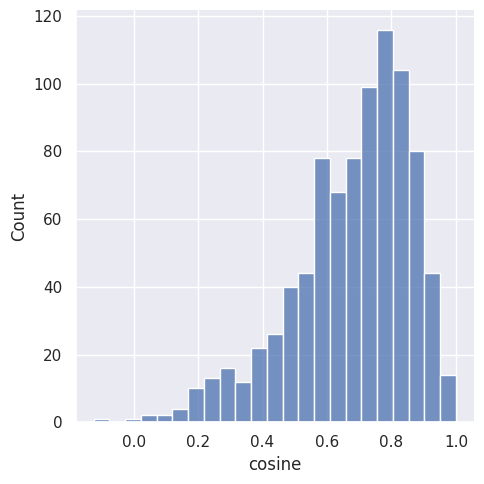

In [ ]:
sns.displot(df.cosine)
plt.show()

### LLM as a Judge


In [ ]:
prompt_template = """
You're an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {original_answer}
Generated Question: {generated_question}
Generated Answer: {generated_answer}

Please analyze the content and context of the generated answer in relation to the original answer and
provide your evaluation in JSON format:

{{
  "Relevance": "NON_RELEVANT" | "PARTIALLY_RELEVANT" | "RELEVANT"
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()